In [1]:
# %%writefile Ind_PondingRate_VIX.py

import sys
import os 
module_path = os.path.abspath(os.path.join('../')) 
if module_path not in sys.path: 
    sys.path.append(module_path)
module_path = os.path.abspath(os.path.join('../../')) 
if module_path not in sys.path: 
    sys.path.append(module_path)
    
import numpy as np
import pandas as pd

import Ind_Model_Base

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import tools.Sample_Tools as smpl
import tools.Pretreat_Tools as pretreat
import Analysis_Funs as af

# %load_ext autoreload
# %autoreload 1
# %aimport Pretreat_Tools,Sample_Tools


class PondingRate(Ind_Model_Base.Ind_Model):
    """对数积水率
        [-1.1]，实际面积与回撤(回调)面积的比（相当于差的积分）
        有方向的，1相当于正向，无齿波，越接近0，抖动频率和幅度越大。
        月现，日线大体上表现一致。
        主要指标是稳健积水率，先对数据做个回归，用回归线再作为实际面积的计算。
        次要指标是使用原始的实际面积
        回报与指标反向。
    """
    optimum_param={'valid':True, 'main':'stably', 'desition_direct':-1, 'window':14, 'freq':'d','neutralize':{'enable':True,'static_mv':False}}
    def __init__(self,data, frequence='day'):
        super().__init__(data, 'PondingRate', frequence)


    def on_set_params_default(self):
        return {'window':14,'moving':5}
    
        
    def on_indicator_structuring(self, data):
        return self.excute_for_multicode(data, self.kernel, **self.pramas)

    
#     def on_desition_structuring(self, data, ind_data):
#         """
#         """
    def getPastLogHigh(self, logVs):
        logHs = [logVs[0]]
        for logV in logVs[1:]:
            if logV>logHs[-1]:
                logHs.append(logV)
            else:
                logHs.append(logHs[-1])
        logHs = np.array(logHs)
        return logHs
    
    # 对数积水率
    def getPoolRate(self, logVs):
        logHs = self.getPastLogHigh(logVs)
        gain = np.sum(logVs) - logVs[0] * len(logVs)
        lost_and_gain = np.sum(logHs) - logHs[0] * len(logHs)
        ninfp1_to_n1p1 = lambda x: 2 / (2 - x) - 1
        poolRate = None
        if gain == 0:
            poolRate = 0
        elif lost_and_gain == 0:
            poolRate = float('-inf')
        else:
            poolRate = gain / lost_and_gain
        poolRate = ninfp1_to_n1p1(poolRate)
        return poolRate
    
    # 稳健对数积水率
    def getPoolRate_stably(self, logVs):
        logHs = self.getPastLogHigh(logVs)
        gain = np.sum(logVs) - logVs[0] * len(logVs)
        lost_and_gain = np.sum(logHs) - logHs[0] * len(logHs)

        lost = lost_and_gain - gain

        dts = np.arange(len(logVs))
        params = af.get_LR_params_fast(dts,logVs)
        s = params[0]
        m = params[-1]
        predLogVs = s * dts + m
        gain = (predLogVs[-1] - predLogVs[0]) * len(logVs) / 2
        lost_and_gain = np.abs(lost + gain)
        ninfp1_to_n1p1 = lambda x: 2 / (2 - x) - 1

        poolRate = None
        if gain == 0:
            poolRate = 0
        elif lost_and_gain == 0:
            poolRate = float('-inf')
        else:
            poolRate = gain / lost_and_gain

        poolRate = ninfp1_to_n1p1(poolRate)
        return poolRate
        
    def kernel(self,dataframe, window=14, moving=5):
        CLOSE = dataframe.close
        CLOSE_log = np.log(CLOSE)
        ind_stably = CLOSE_log.rolling(window).apply(lambda x:self.getPoolRate_stably(x))
        
        if self.fast_mode:
            return pd.DataFrame({'stably':ind_stably}) 
            
        ind_unstably = CLOSE_log.rolling(window).apply(lambda x:self.getPoolRate(x))
        print(ind_unstably)
        return pd.DataFrame({'stably':ind_stably, 'unstably':ind_unstably})

    
    def plot(self,):
        groups = self.ind_df.groupby(level=1)
        fig = plt.figure(figsize=(1120/72,210*len(groups)/72))
        for idx,item in enumerate(groups):
            inds_ = item[1].reset_index('code',drop=True)
            ax = fig.add_subplot(len(groups),1,idx+1)
            
            
            ##axis不转成字符串的话，bar和line的x轴有时候对不上，原因未知
            formater = '%Y%m%d' if self.is_low_frequence else '%Y%m%d %H%M%S'
            index_ = [pd.to_datetime(x).strftime(formater) for x in inds_.index.values]
            # index_ = inds_.index.values
#             d = item[1].reset_index(('date','code'),drop=True)

            ax.set_title(item[0],color='blue', loc ='left', pad=-10) 
    
            close = self.data.close.loc[(slice(None),item[0])]
            close.index = index_
            close.plot(kind='line', ax=ax)
            
            ax2 = ax.twinx()
            ax2.set_ylim([-1,1])
            
            main = inds_[PondingRate.optimum_param['main']]
            main.index = index_
            main.plot(kind='line', color='black', ax=ax2,label='stably')
            
            if not self.fast_mode:
                sub = inds_['unstably']
                sub.index = index_
                sub.plot(kind='line', ax=ax2, color='grey',label='unStably')
                ax.xaxis.set_major_locator(ticker.MaxNLocator(10))
                
            plt.legend(loc='lower left', fontsize=10) 
            plt.xticks(rotation = 0)


ModuleNotFoundError: No module named 'Ind_Model_Base'

date        code  
2020-08-24  600010         NaN
            600028         NaN
            600030         NaN
            600031         NaN
            600036         NaN
                        ...   
2021-09-03  603260    0.928024
            603288   -0.662202
            603501   -0.873439
            603799    0.124275
            603986   -0.884449
Name: stably, Length: 12161, dtype: float64


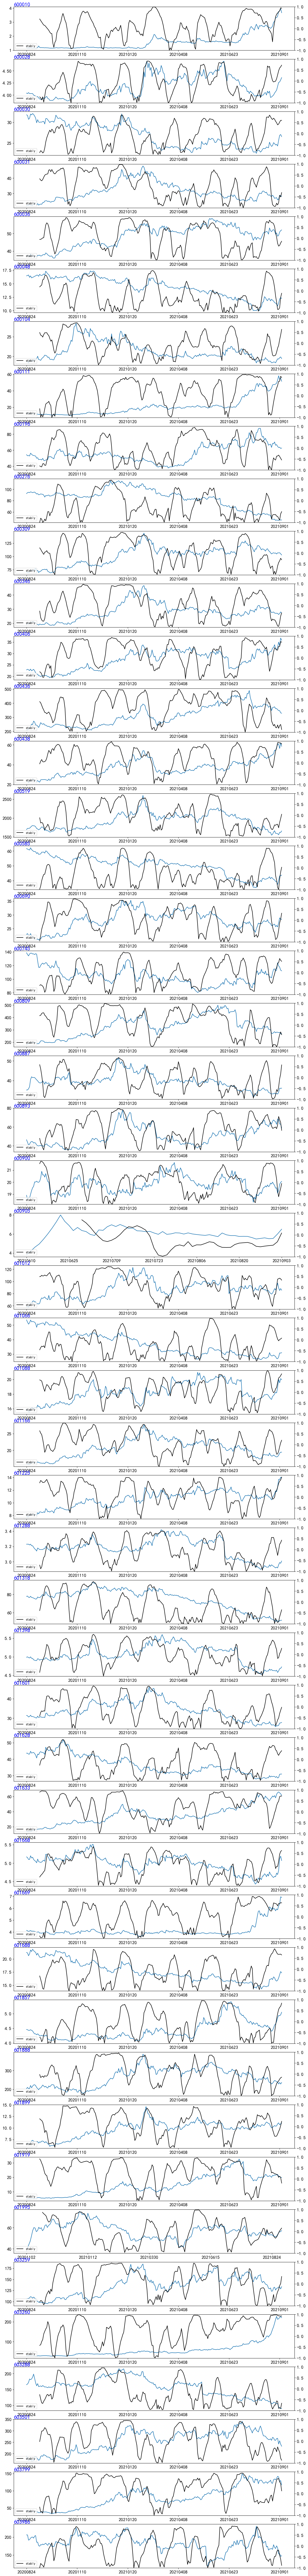

In [2]:
# from tools.Test_Tools import FactorTest

data = smpl.get_sample_by_zs(name='上证50', end='2021-09-03', gap=252, only_main=True)
# data = smpl.get_data(['000001','000002','000004','000005','000006'], end='2021-09-03', gap=150)
# df_re = smpl.resample_stockdata_low(data.data,'M')
p = PondingRate(data)
p.change_pramas(window=14)
# p.set_ignore_sub_ind(False)
p.fit()

p.plot()     
print(p.ind_df['stably'])

In [4]:
%%time

from tools.Test_Tools import FactorTest
import Ind_PondingRate_VIX
%load_ext autoreload
%autoreload 1
%aimport tools.Test_Tools,Ind_PondingRate_VIX

test2 = FactorTest(Ind_PondingRate_VIX.PondingRate, sample='沪深300',freq="m",end='2020-06-29',gap=2500,only_main=True,neutralize={'enable':False,'static_mv':False})

test2.process_multi()
test2.plot()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Now in the main code. Process name is: base.JuUnits
base.JuUnits, subpid:1846202  pid:1846082


/opt/quant/lib/python3.8/site-packages/pymongo/topology.py:161: UserWarning: MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe
  warnings.warn(


  0%|          | 0/4 [00:00<?, ?it/s]

/opt/quant/lib/python3.8/site-packages/pymongo/topology.py:161: UserWarning: MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe
  warnings.warn(
/opt/quant/lib/python3.8/site-packages/pymongo/topology.py:161: UserWarning: MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe
  warnings.warn(
/opt/quant/lib/python3.8/site-packages/pymongo/topology.py:161: UserWarning: MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe
  warnings.warn(


ValueError: data type <class 'numpy.object_'> not inexact

In [7]:
%%time

from tools.Test_Tools import FactorTest
import Ind_PondingRate_VIX
%load_ext autoreload
%autoreload 1
%aimport tools.Test_Tools,Ind_PondingRate_VIX

test2 = FactorTest(Ind_PondingRate_VIX.PondingRate, sample='沪深300',freq="d",end='2020-06-29',gap=252,only_main=True,neutralize={'enable':True,'static_mv':False})

test2.process_multi()
test2.plot()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


FileNotFoundError: [Errno 2] No such file or directory: '../multi_fun_box/FactorTest_deal.py'

In [17]:
import sys
sys.path 

['D:\\PyProjects\\IndicatorLab',
 'D:\\Anaconda3\\python38.zip',
 'D:\\Anaconda3\\DLLs',
 'D:\\Anaconda3\\lib',
 'D:\\Anaconda3',
 '',
 'D:\\Anaconda3\\lib\\site-packages',
 'd:\\pyprojects\\quantaxis',
 'D:\\Anaconda3\\lib\\site-packages\\locket-0.2.1-py3.8.egg',
 'D:\\Anaconda3\\lib\\site-packages\\win32',
 'D:\\Anaconda3\\lib\\site-packages\\win32\\lib',
 'D:\\Anaconda3\\lib\\site-packages\\Pythonwin',
 'D:\\Anaconda3\\lib\\site-packages\\IPython\\extensions',
 'C:\\Users\\fakeQ\\.ipython']